<a href="https://colab.research.google.com/github/VMBoehm/UndergradStudentProjects/blob/master/Jamie_and_Lister/VanessasNotebooks/PeakCounts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# applying our methods to lensing convergence peak counts

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:

datapath='../data/'


### load the data

In [3]:
data_scaled = np.load(datapath+'peakcnts_lhc.scaled.npy',allow_pickle=True)
cosmo_params = np.load(datapath+'params.npy')
covariance = np.load(datapath+'covariance.npy',allow_pickle=True)

In [39]:
data_scaled.shape

(101, 9999, 50)

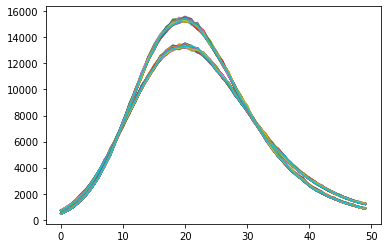

In [42]:
plt.plot(data_scaled[40,0:100,:].T)
plt.plot(data_scaled[44,0:100,:].T)
plt.show()

In [4]:
means = np.mean(data_scaled, axis=1)

In [5]:
fid_params = np.load(datapath+'theta.fid.npy',allow_pickle=True)

In [6]:
index = 55
data  = data_scaled[index][0]
true_params = cosmo_params[index]
print(true_params)

[0.41504 0.3097  2.3486 ]


In [29]:
data

array([  422.63443438,   627.17921939,   915.61574727,  1295.38198784,
        1775.66157106,  2349.76998717,  3092.96851238,  3991.80893946,
        5076.74537642,  6163.37739276,  7332.17063374,  8575.51826722,
        9860.35061095, 11332.58326042, 12390.42996868, 13429.73357219,
       14311.04987402, 15081.83888297, 15477.21007133, 15586.26187853,
       15572.94526727, 15716.62726201, 15365.37615507, 14692.96820015,
       14013.73482947, 13181.37847406, 12417.44516468, 11364.34864681,
       10458.89824266,  9480.50751018,  8692.53442811,  7727.36597727,
        6949.02254444,  6099.64281882,  5469.32980071,  4887.01714029,
        4349.51397556,  3917.0589052 ,  3425.55773301,  2922.37613815,
        2594.08643363,  2212.15063808,  1930.40094747,  1678.85731486,
        1510.49388639,  1299.07127736,  1160.39568242,  1005.77276006,
         865.29211421,   770.9846507 ])

### Covariance Matrix

In [7]:
# compute covariance from covariance sims
Cinv = np.linalg.inv(covariance)

### Gaussian process interpolation of (precompressed) data

In [8]:
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (1e-4, 1e4)) * RBF(1, (1e-4, 1e4))
#Instanciate a Gaussian Process model
gp     = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)


# fit on averages of full rescaled set
gp.fit(cosmo_params,means)

#use the GP prediction to build the model
def fwdmodel(theta):
    pred, stdev = gp.predict(np.array(theta).reshape(1,3),return_std=True)
    return np.squeeze(pred.T)

# compute derivative of mean at fiducial model with finite differencing


In [30]:
# likelihood
def likelihood(data, params):
    mu  = fwdmodel(params)
    x   = data - mu
    logp= -0.5*np.dot(np.dot(x, Cinv),x)#+0.5*np.log(np.linalg.det(Cinv))-0.5*np.log(2*np.pi)
    return np.squeeze(logp)

In [ ]:
# posterior= prior*likelihood
# add a prior



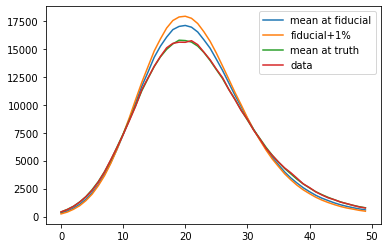

In [31]:
plt.plot(fwdmodel(fid_params), label='mean at fiducial')
plt.plot(fwdmodel(fid_params*1.01), label= 'fiducial+1%')
plt.plot(fwdmodel(true_params), label='mean at truth')
plt.plot(data, label='data')
plt.legend()

In [32]:
neglogpost = lambda x: -likelihood(data, x)

In [33]:
import numdifftools as nd

In [34]:
grad = nd.Gradient(neglogpost)

In [35]:
hess = nd.Hessian(neglogpost)

In [36]:
def derivative(params):
    delta_params=0.001*fid_params
    deriv = np.zeros(len(params))
    for ii in range(len(params)):
        deltas = np.zeros(len(params))
        deltas[ii]+=delta_params[ii]
        deriv[ii] = (neglogpost(params+deltas)-neglogpost(params-deltas))/(2*delta_params[ii])
    return deriv

In [37]:
grad(true_params), derivative(true_params)

(array([ 0.57586184, -0.03298548,  1.09513708]),
 array([ 0.57610767, -0.03447856,  1.87808741]))

In [158]:
from scipy.optimize import minimize

log_posts = [] 
results = []
for theta_ini in np.sqrt(theta_fiducial)*np.random.randn(10,3)+theta_fiducial:
  print(theta_ini)
  for method in ['Powell']:#['Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']:
    res = minimize(neglogpost,theta_ini,jac=grad,hess=hess,method=method)
    log_posts.append(neglogpost(res['x']))
    results.append(res['x'])

[ 0.29216898 -0.24259243  2.30772382]
Powell 0.03370247919753608
[-0.53346392  1.07019946  0.02602707]
Powell 33.94867904728181
[0.52270522 0.78504397 3.10765817]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)


Powell 0.020701571927158696
[ 0.21653883  0.92299313 -0.10584775]
Powell 39.65814215672481
[ 0.0136755  -0.17375627  0.60340296]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)


Powell 0.03377883583456115
[-0.43702737  0.0990827   1.62911691]
Powell 0.11326632832565463
[0.47143827 0.87576294 2.96016304]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)


Powell 0.020664425873722105
[0.40136408 0.97320782 2.67746087]
Powell 0.16682321992694893
[-0.60274434  0.14132331  3.23786896]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)


Powell 0.020735770540413923
[-0.0173851  -0.2678118   2.11251385]
Powell 0.0036251789026392994


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:511: RuntimeWarning: Method Powell does not use Hessian information (hess).
  RuntimeWarning)


In [0]:
index       = np.argsort((log_posts))
best_params = results[index[0]]

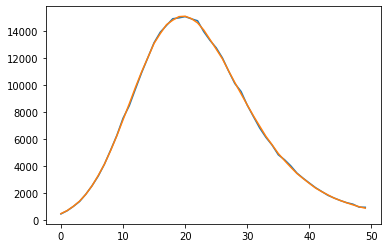

In [163]:
plt.plot(data)
plt.plot(fwdmodel(best_params))